# **CAPTCHA Recognition using CRNN**

___

## **Data Preprocessing**

- Load the CAPTCHA images
- Resize them to a consistent dimension
- Normalize pixel values to range [0,1]
- Convert text labels to numerical format (One-hot encoding)

___

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
np.random.seed(42)
random.seed(42)

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parsasam/captcha-dataset")

print("Path to dataset files:", path)

Resuming download from 321912832 bytes (51302502 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/parsasam/captcha-dataset?dataset_version_number=1 (321912832/373215334) bytes left.


100%|██████████| 356M/356M [03:39<00:00, 234kB/s]

Extracting files...


Path to dataset files: C:\Users\tahaa\.cache\kagglehub\datasets\parsasam\captcha-dataset\versions\1


In [3]:
dataset_path = r"Dataset\captcha-dataset"

captcha_files = [f for f in os.listdir(dataset_path) if f.endswith(".jpg")]
print(f"Total number of CAPTCHA images: {len(captcha_files)}")

chars = set()
captcha_lengths = []

for file in captcha_files:
    label = os.path.splitext(file)[0]
    captcha_lengths.append(len(label))
    for char in label:
        chars.add(char)
        
chars = ''.join(sorted(chars))
max_length = max(captcha_lengths)

print(f"Unique characters in the dataset: {chars}")
print(f"Total number of unique characters: {len(chars)}")
print(f"Maximum CAPTCHA length: {max_length}")

Total number of CAPTCHA images: 113062
Unique characters in the dataset: 123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnpqrstuvwxyz
Total number of unique characters: 60
Maximum CAPTCHA length: 5


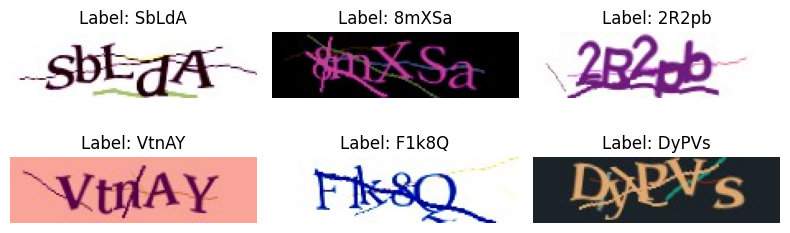

In [4]:
plt.figure(figsize=(8, 3))
for i in range(6):
    if i < len(captcha_files):
        random_idx = random.randint(0, len(captcha_files)-1)
        captcha_path = os.path.join(dataset_path, captcha_files[random_idx])
        captcha = cv2.imread(captcha_path)
        captcha = cv2.cvtColor(captcha, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, 3, i+1)
        plt.imshow(captcha)
        label = os.path.splitext(captcha_files[random_idx])[0]
        plt.title(f"Label: {label}")
        plt.axis("off")
        
plt.tight_layout()
plt.show()

In [5]:
dataset_path = r"Dataset\captcha-dataset"
captcha_height = 40
captcha_width = 150
channels = 1

def preprocess_captcha(dataset_path, height=captcha_height, width=captcha_width, channels=channels, cache=True):
    
    cache_dir = os.path.join(dataset_path, "preprocessed_cache")
    os.makedirs(cache_dir, exist_ok=True)
    X_path = os.path.join(cache_dir, "images.npy")
    y_path = os.path.join(cache_dir, "labels.npy")
    
    if cache and os.path.exists(X_path) and os.path.exists(y_path):
        print("Loading cached preprocessed data...")
        return np.load(X_path), np.load(y_path, allow_pickle=True).tolist()
    
    images = []
    labels = []
    
    captcha_files = [f for f in os.listdir(dataset_path) if f.endswith((".jpg"))]
    
    fail_count = 0
    
    for captcha_file in tqdm(captcha_files, desc="Processing CAPTCHAs"):
        try:
            label = os.path.splitext(captcha_file)[0]
            captcha_path = os.path.join(dataset_path, captcha_file)
            captcha = cv2.imread(captcha_path)
            
            if channels == 1:
                captcha = cv2.cvtColor(captcha, cv2.COLOR_BGR2GRAY)
            
            captcha = cv2.resize(captcha, (width, height))
            
            captcha = captcha.astype(np.float32) / 255.0
            
            if channels == 1:
                captcha = captcha.reshape(height, width, 1)
            
            images.append(captcha)
            labels.append(label)
        
        except Exception as e:
            print(f"Error processing {captcha_file}: {e}")
            fail_count += 1
            continue
    
    images = np.array(images)
    
    np.save(X_path, images)
    np.save(y_path, np.array(labels))

    print(f"Processed and saved {len(images)} images.")
    return images, labels

X, y_text = preprocess_captcha(dataset_path)

Processing CAPTCHAs: 100%|██████████| 113062/113062 [00:44<00:00, 2513.05it/s]


Processed and saved 113062 images.


Loaded image array shape: (113062, 40, 150, 1)
Loaded label list length: 113062
Sample label: 111J8


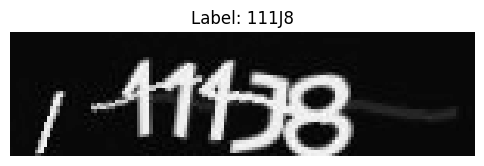

In [5]:
cache_dir = r"Dataset\captcha-dataset\preprocessed_cache"

X = np.load(os.path.join(cache_dir, 'images.npy'))
y_text = np.load(os.path.join(cache_dir, 'labels.npy'), allow_pickle=True)

print(f"Loaded image array shape: {X.shape}")
print(f"Loaded label list length: {len(y_text)}")
print(f"Sample label: {y_text[0]}")

plt.figure(figsize=(6, 4))
plt.imshow(X[0].squeeze(), cmap='gray')
plt.title(f"Label: {y_text[0]}")
plt.axis('off')
plt.show()

In [7]:
def encode_labels(labels, char_set, max_length, cache_dir):

    os.makedirs(cache_dir, exist_ok=True)
    sparse_path = os.path.join(cache_dir, "sparse_labels.npy")
    onehot_path = os.path.join(cache_dir, "onehot_labels.npy")

    if os.path.exists(sparse_path) and os.path.exists(onehot_path):
        print("Loading encoded labels ...")
        sparse_labels = np.load(sparse_path, allow_pickle=True)
        one_hot_labels = np.load(onehot_path)

    else:
        print("Encoding labels and saving ...")
        char_to_idx = {char: idx for idx, char in enumerate(char_set)}
        
        sparse_labels = []
        one_hot_labels = []

        for label in tqdm(labels, desc="Endocing labels"):
            try:
                sparse_labels.append([char_to_idx[c] for c in label if c in char_to_idx])

                padded_label = label.ljust(max_length)[:max_length]
                one_hot = np.zeros((max_length, len(char_set)))
                
                for i, char in enumerate(padded_label):
                    if char in char_to_idx:
                        one_hot[i, char_to_idx[char]] = 1

                one_hot_labels.append(one_hot)
            
            except Exception as e:
                print(f"Error encoding label '{label}': {e}")
                continue

        np.save(sparse_path, np.array(sparse_labels, dtype=object))
        np.save(onehot_path, np.array(one_hot_labels))

    return {'sparse': sparse_labels,
            'one_hot': np.array(one_hot_labels)}

encoded_labels = encode_labels(y_text, chars, max_length, cache_dir)

print(f"Sample text label: {y_text[0]}")
print(f"Corresponding sparse encoding: {encoded_labels['sparse'][0]}")
print(f"One-hot encoding shape: {encoded_labels['one_hot'].shape}")

Encoding labels and saving ...


Endocing labels: 100%|██████████| 113062/113062 [00:00<00:00, 119533.26it/s]


Sample text label: 111J8
Corresponding sparse encoding: [0, 0, 0, 18, 7]
One-hot encoding shape: (113062, 5, 60)


___

## **CRNN Model**

- CRNN with Conv2D
- Sequence Learning using RNN (bidirectional LSTM)
- CTC Loss for Sequence-to-Sequence Alignment

___

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [7]:
captcha_height = 40
captcha_width = 150
channels = 1

max_captcha_length = max_length
characters = list(chars)
blank_char = ' '
chars = [blank_char] + list(characters)
num_classes = len(chars)

print(num_classes)

61


In [8]:
class CRNN(nn.Module):
    def __init__(self, img_height, num_channels, num_classes, rnn_hidden_size=256, num_rnn_layers=2):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),

            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)))

        cnn_output_height = img_height // 16
        self.rnn_input_size = 512 * cnn_output_height

        self.rnn = nn.LSTM(
            input_size=self.rnn_input_size,
            hidden_size=rnn_hidden_size,
            num_layers=num_rnn_layers,
            bidirectional=True,
            batch_first=False)

        self.fc = nn.Linear(rnn_hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        B, C, H, W = x.size()
        x = x.permute(3, 0, 1, 2)
        x = x.contiguous().view(W, B, -1)
        x, _ = self.rnn(x)
        x = self.fc(x)
        
        return x

In [9]:
model = CRNN(img_height=40, num_channels=1, num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

summary(model, input_size=(1, 1, 40, 150), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CRNN                                     [1, 1, 40, 150]           [37, 1, 61]               --
├─Sequential: 1-1                        [1, 1, 40, 150]           [1, 512, 2, 37]           --
│    └─Conv2d: 2-1                       [1, 1, 40, 150]           [1, 64, 40, 150]          640
│    └─ReLU: 2-2                         [1, 64, 40, 150]          [1, 64, 40, 150]          --
│    └─MaxPool2d: 2-3                    [1, 64, 40, 150]          [1, 64, 20, 75]           --
│    └─Conv2d: 2-4                       [1, 64, 20, 75]           [1, 128, 20, 75]          73,856
│    └─ReLU: 2-5                         [1, 128, 20, 75]          [1, 128, 20, 75]          --
│    └─MaxPool2d: 2-6                    [1, 128, 20, 75]          [1, 128, 10, 37]          --
│    └─Conv2d: 2-7                       [1, 128, 10, 37]          [1, 256, 10, 37]          295,168
│    └─ReLU: 2-8         

___

## **Training**

- Training the model with monitorization

___

In [10]:
import json
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm

In [11]:
class CAPTCHADataset(Dataset):
    def __init__(self, images_path, sparse_labels_path, text_labels_path, chars):
        self.images = np.load(images_path)
        self.sparse_labels = np.load(sparse_labels_path, allow_pickle=True)
        self.text_labels = np.load(text_labels_path, allow_pickle=True)
        self.chars = chars
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        
        if len(image.shape) == 3 and image.shape[2] == 1:
            image = image.transpose(2, 0, 1)
        elif len(image.shape) == 2:
            image = image[np.newaxis, :, :]
            
        image = torch.FloatTensor(image)
        
        sparse_label = self.sparse_labels[idx]
        if isinstance(sparse_label, np.ndarray) and sparse_label.dtype == np.object_:
            sparse_label = list(sparse_label)
        elif isinstance(sparse_label, np.ndarray):
            sparse_label = sparse_label.tolist()
        
        if len(sparse_label) == 0:
            sparse_label = [1]
            
        sparse_label = [idx + 1 for idx in sparse_label] # type: ignore
            
        label_tensor = torch.LongTensor(sparse_label)
        text_label = self.text_labels[idx]
        
        return image, label_tensor, len(sparse_label), text_label

def collate_fn(batch):
    images, labels, label_lengths, label_texts = zip(*batch)
    images = torch.stack(images, 0)
    
    concatenated_targets = []
    for label in labels:
        concatenated_targets.extend(label.tolist())
    
    targets = torch.LongTensor(concatenated_targets)
    target_lengths = torch.LongTensor(label_lengths)
    
    return images, targets, target_lengths, list(label_texts)

def decode_predictions(logits, chars, method='best_path'):
    predictions = []
    
    if method == 'best_path':
        probs = F.softmax(logits, dim=2)
        _, pred_indices = torch.max(probs, dim=2)
        
        for i in range(pred_indices.size(1)):
            indices = pred_indices[:, i].cpu().numpy()
            
            decoded = []
            prev_idx = -1
            
            for idx in indices:
                if idx != 0 and idx != prev_idx:
                    if idx < len(chars):
                        decoded.append(chars[idx])
                prev_idx = idx
                
            predictions.append(''.join(decoded))
    
    return predictions

def calculate_accuracy(predictions, targets, method='exact'):
    if not predictions or not targets:
        return 0.0
        
    if method == 'exact':
        correct = sum(1 for pred, target in zip(predictions, targets) if pred == target)
        return correct / len(predictions)
    
    elif method == 'character':
        total_chars = 0
        correct_chars = 0
        
        for pred, target in zip(predictions, targets):
            max_len = max(len(pred), len(target))
            if max_len == 0:
                continue
                
            total_chars += max_len
            min_len = min(len(pred), len(target))
            
            for j in range(min_len):
                if pred[j] == target[j]:
                    correct_chars += 1
                    
        return correct_chars / total_chars if total_chars > 0 else 0.0

class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-3, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights and self.best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

class TrainingMonitor:
    def __init__(self, save_dir='training_logs'):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_accuracy': [],
            'val_accuracy': [],
            'learning_rates': [],
            'epoch_times': []}
        
        self.best_val_loss = float('inf')
        self.best_val_accuracy = 0.0
        self.total_start_time = None
        
    def start_training(self, total_epochs):
        self.total_epochs = total_epochs
        self.total_start_time = time.time()
        print(f"Starting training for {total_epochs} epochs...")
        print("=" * 70)
        
    def log_epoch(self, epoch, train_loss, val_loss, train_acc, val_acc, lr, epoch_time):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_accuracy'].append(train_acc)
        self.history['val_accuracy'].append(val_acc)
        self.history['learning_rates'].append(lr)
        self.history['epoch_times'].append(epoch_time)
        
        is_best_loss = val_loss < self.best_val_loss
        is_best_acc = val_acc > self.best_val_accuracy
        
        if is_best_loss:
            self.best_val_loss = val_loss
        if is_best_acc:
            self.best_val_accuracy = val_acc
            
        status = ""
        if is_best_loss and is_best_acc:
            status = " BEST!"
        elif is_best_loss:
            status = " Best Loss"
        elif is_best_acc:
            status = " Best Acc"
            
        print(f"Epoch [{epoch+1:3d}/{self.total_epochs}] | "
              f"Loss: {train_loss:.3f}/{val_loss:.3f} | "
              f"Acc: {train_acc:.3f}/{val_acc:.3f} | "
              f"LR: {lr:.1e} | {epoch_time:.1f}s{status}")
        
        if (epoch + 1) % 10 == 0:
            self.save_metrics()
            
    def plot_training_curves(self):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        epochs = range(1, len(self.history['train_loss']) + 1)
        
        ax1.plot(epochs, self.history['train_loss'], 'b-', label='Training Loss', alpha=0.8)
        ax1.plot(epochs, self.history['val_loss'], 'r-', label='Validation Loss', alpha=0.8)
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(epochs, self.history['train_accuracy'], 'b-', label='Training Accuracy', alpha=0.8)
        ax2.plot(epochs, self.history['val_accuracy'], 'r-', label='Validation Accuracy', alpha=0.8)
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        ax3.plot(epochs, self.history['learning_rates'], 'g-', alpha=0.8)
        ax3.set_title('Learning Rate Schedule')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
        
        ax4.plot(epochs, self.history['epoch_times'], 'm-', alpha=0.8)
        ax4.set_title('Epoch Training Time')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Time (seconds)')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
    def save_metrics(self):
        metrics_path = os.path.join(self.save_dir, 'training_metrics.json')
        with open(metrics_path, 'w') as f:
            json.dump(self.history, f, indent=2)
            
    def print_final_summary(self):
        if self.total_start_time is None:
            total_time = 0
        else:
            total_time = time.time() - self.total_start_time
        
        avg_epoch_time = np.mean(self.history['epoch_times']) if self.history['epoch_times'] else 0
        
        print("\n" + "=" * 70)
        print(" TRAINING COMPLETED!")
        print("=" * 70)
        print(f" Final Results:")
        print(f"   Best Validation Loss: {self.best_val_loss:.4f}")
        print(f"   Best Validation Accuracy: {self.best_val_accuracy:.3f}")
        print(f"   Total Training Time: {total_time/3600:.2f} hours")
        print(f"   Average Epoch Time: {avg_epoch_time:.1f} seconds")
        print(f"   Total Epochs: {len(self.history['train_loss'])}")
        print("=" * 70)

def prepare_dataloaders(images_path, sparse_labels_path, text_labels_path, chars, 
                       batch_size=32, val_split=0.15, test_split=0.1):
    dataset = CAPTCHADataset(images_path, sparse_labels_path, text_labels_path, chars)
    
    total_size = len(dataset)
    test_size = int(total_size * test_split)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size - test_size
    
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size], generator=generator)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False)
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False)
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False)  
    
    print(f" Dataset prepared: Train: {train_size}, Val: {val_size}, Test: {test_size}")
    return train_loader, val_loader, test_loader

def validate_epoch(model, dataloader, criterion, device, chars):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    batch_count = 0
    
    val_loop = tqdm(dataloader, desc=" Validation", leave=False)

    with torch.no_grad():
        for images, targets, target_lengths, target_texts in val_loop:
            try:
                images = images.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                target_lengths = target_lengths.to(device, non_blocking=True)
                
                logits = model(images)
                log_probs = F.log_softmax(logits, dim=2)
                
                input_lengths = torch.full(
                    size=(images.size(0),), 
                    fill_value=logits.size(0),
                    dtype=torch.long).to(device)
                
                loss = criterion(log_probs, targets, input_lengths, target_lengths)
                
                if not (torch.isnan(loss) or torch.isinf(loss)):
                    total_loss += loss.item()
                    batch_count += 1
                
                avg_loss = loss.item() / images.size(0) if not torch.isnan(loss) else 0
                val_loop.set_postfix({"val_loss": f"{avg_loss:.4f}"})
                
                decoded = decode_predictions(logits, chars)
                all_predictions.extend(decoded)
                all_targets.extend(target_texts)
                
            except Exception as e:
                print(f" Error in validation batch: {e}")
                continue

    avg_loss = total_loss / batch_count if batch_count > 0 else float('inf')
    accuracy = calculate_accuracy(all_predictions, all_targets)

    save_predictions_to_csv(all_predictions, all_targets)
    
    return avg_loss, accuracy

def print_sample_predictions(predictions, targets, epoch, num_samples=5):
    """Print sample predictions for debugging"""
    if not predictions or not targets:
        return
        
    print(f"\n Sample predictions (Epoch {epoch+1}):")
    for i in range(min(num_samples, len(predictions))):
        pred = predictions[i] if i < len(predictions) else ""
        target = targets[i] if i < len(targets) else ""
        match = "TRUE" if pred == target else "FALSE"
        print(f"   {match} Predicted: '{pred}' | Target: '{target}'")
        
def save_predictions_to_csv(predictions, targets, save_path='training_logs/predictions.csv'):
    df = pd.DataFrame({
        'Predicted': predictions,
        'Actual': targets})
    df.to_csv(save_path, index=False)
    print(f" Predictions saved to {save_path}")

def train_model(model, images_path, sparse_labels_path, text_labels_path, chars, device, 
                epochs=80, batch_size=32, lr=3e-4, weight_decay=1e-4):
    print(f" Training Configuration:")
    print(f"   Device: {device}")
    print(f"   Epochs: {epochs}")
    print(f"   Batch Size: {batch_size}")
    print(f"   Learning Rate: {lr}")
    print(f"   Weight Decay: {weight_decay}")
    print(f"   Number of Classes: {len(chars)}")
    print(f"   Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    train_loader, val_loader, test_loader = prepare_dataloaders(
        images_path, sparse_labels_path, text_labels_path, chars, batch_size)

    criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=lr, 
        weight_decay=weight_decay,
        betas=(0.9, 0.999),
        eps=1e-8)
    
    total_steps = len(train_loader) * epochs
    scheduler = OneCycleLR(
        optimizer,
        max_lr=lr * 3,
        total_steps=total_steps,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=10.0,
        final_div_factor=100.0)
    
    early_stopper = EarlyStopping(patience=20, min_delta=1e-3)
    monitor = TrainingMonitor()
    monitor.start_training(epochs)
    
    model.to(device)
    
    def init_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight' in name:
                    nn.init.kaiming_normal_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0)
    
    model.apply(init_weights)
    
    for epoch in range(epochs):
        start_time = time.time()
        
        model.train()
        train_loss = 0
        all_predictions = []
        all_targets = []
        batch_count = 0
        
        epoch_pbar = tqdm(train_loader, desc=f" Epoch {epoch+1}/{epochs}", leave=False)

        for batch_idx, (images, targets, target_lengths, target_texts) in enumerate(epoch_pbar):
            try:
                images = images.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                target_lengths = target_lengths.to(device, non_blocking=True)
                
                optimizer.zero_grad()
                
                logits = model(images)
                log_probs = F.log_softmax(logits, dim=2)
                
                input_lengths = torch.full(
                    size=(images.size(0),), 
                    fill_value=logits.size(0),
                    dtype=torch.long).to(device)
                
                loss = criterion(log_probs, targets, input_lengths, target_lengths)
                
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f" Invalid loss detected at batch {batch_idx}, skipping...")
                    continue
                
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                
                optimizer.step()
                scheduler.step()

                train_loss += loss.item()
                batch_count += 1
                
                epoch_pbar.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "avg_loss": f"{train_loss/batch_count:.4f}",
                    "lr": f"{optimizer.param_groups[0]['lr']:.2e}"})

                if batch_idx % 500 == 0:
                    with torch.no_grad():
                        decoded = decode_predictions(logits.detach(), chars)
                        sample_size = min(len(decoded), len(target_texts), 8)
                        all_predictions.extend(decoded[:sample_size])
                        all_targets.extend(target_texts[:sample_size])
                        
            except Exception as e:
                print(f" Error in training batch {batch_idx}: {e}")
                continue
        
        epoch_pbar.close()
        
        avg_train_loss = train_loss / batch_count if batch_count > 0 else float('inf')
        train_accuracy = calculate_accuracy(all_predictions, all_targets) if all_predictions else 0.0

        val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, device, chars)

        current_lr = optimizer.param_groups[0]['lr']
        epoch_time = time.time() - start_time
        
        monitor.log_epoch(
            epoch, avg_train_loss, val_loss, 
            train_accuracy, val_accuracy, 
            current_lr, epoch_time)
        
        best_model_path = os.path.join(monitor.save_dir, "best_model.pth")
        latest_model_path = os.path.join(monitor.save_dir, "latest_model.pth")

        if val_loss < monitor.best_val_loss:
            torch.save(model.state_dict(), best_model_path)

        torch.save(model.state_dict(), latest_model_path)

        if epoch % 5 == 0 and all_predictions:
            print_sample_predictions(all_predictions, all_targets, epoch)

        if early_stopper(val_loss, model):
            print(f"\n Early stopping triggered at epoch {epoch+1}")
            break

    monitor.plot_training_curves()
    monitor.save_metrics()
    monitor.print_final_summary()

    model_path = os.path.join(monitor.save_dir, 'crnn_best_model.pth')
    torch.save(model.state_dict(), model_path)
    print(f" Model saved to: {model_path}")
    
    print("\n Testing final model...")
    test_loss, test_accuracy = validate_epoch(model, test_loader, criterion, device, chars)
    print(f" Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.3f}")
    
    return model, monitor.history

Using device: cuda
 Training Configuration:
   Device: cuda
   Epochs: 60
   Batch Size: 32
   Learning Rate: 0.0003
   Weight Decay: 0.0001
   Number of Classes: 61
   Model Parameters: 8,735,037
 Dataset prepared: Train: 84797, Val: 16959, Test: 11306
Starting training for 60 epochs...


 Predictions saved to training_logs/predictions.csv
Epoch [  1/60] | Loss: 4.097/3.547 | Acc: 0.000/0.000 | LR: 1.4e-04 | 242.6s Best Loss

 Sample predictions (Epoch 1):
   FALSE Predicted: 'wab7w7w7XbXwap' | Target: 'A4zAa'
   FALSE Predicted: 'FbTnTn5WFnan5Fa' | Target: 'X4wdO'
   FALSE Predicted: 'bfaRwRvnbnan' | Target: '1XrGk'
   FALSE Predicted: 'CJCaXaThahtItXCWBQ' | Target: '53Sm6'
   FALSE Predicted: 'b6GXnthnQn4t' | Target: 'gLOIV'


 Predictions saved to training_logs/predictions.csv
Epoch [  2/60] | Loss: 2.304/1.169 | Acc: 0.021/0.143 | LR: 2.9e-04 | 242.1s BEST!


 Predictions saved to training_logs/predictions.csv
Epoch [  3/60] | Loss: 0.642/0.471 | Acc: 0.417/0.559 | LR: 5.0e-04 | 241.9s BEST!


 Predictions saved to training_logs/predictions.csv
Epoch [  4/60] | Loss: 0.395/0.370 | Acc: 0.521/0.618 | LR: 7.0e-04 | 242.9s BEST!


 Predictions saved to training_logs/predictions.csv
Epoch [  5/60] | Loss: 0.315/0.335 | Acc: 0.667/0.642 | LR: 8.5e-04 | 242.3s BEST!


 Predictions saved to training_logs/predictions.csv
Epoch [  6/60] | Loss: 0.264/0.269 | Acc: 0.792/0.691 | LR: 9.0e-04 | 242.0s BEST!

 Sample predictions (Epoch 6):
   TRUE Predicted: 'peTbm' | Target: 'peTbm'
   TRUE Predicted: 'EuKRg' | Target: 'EuKRg'
   TRUE Predicted: 'lGUFt' | Target: 'lGUFt'
   FALSE Predicted: 'ZLlea' | Target: 'ZLIea'
   TRUE Predicted: 'ROw2P' | Target: 'ROw2P'


 Predictions saved to training_logs/predictions.csv
Epoch [  7/60] | Loss: 0.223/0.250 | Acc: 0.771/0.699 | LR: 9.0e-04 | 241.9s BEST!


 Predictions saved to training_logs/predictions.csv
Epoch [  8/60] | Loss: 0.202/0.243 | Acc: 0.812/0.718 | LR: 9.0e-04 | 242.1s BEST!


 Predictions saved to training_logs/predictions.csv
Epoch [  9/60] | Loss: 0.189/0.240 | Acc: 0.792/0.724 | LR: 8.9e-04 | 241.9s BEST!


 Predictions saved to training_logs/predictions.csv
Epoch [ 10/60] | Loss: 0.178/0.218 | Acc: 0.688/0.733 | LR: 8.9e-04 | 248.1s BEST!


 Predictions saved to training_logs/predictions.csv
Epoch [ 11/60] | Loss: 0.172/0.218 | Acc: 0.792/0.729 | LR: 8.8e-04 | 244.5s

 Sample predictions (Epoch 11):
   TRUE Predicted: 'Up3bj' | Target: 'Up3bj'
   TRUE Predicted: 'CziZG' | Target: 'CziZG'
   TRUE Predicted: 'ESUEl' | Target: 'ESUEl'
   TRUE Predicted: 'yX2kP' | Target: 'yX2kP'
   FALSE Predicted: 'IVXM3' | Target: '1VXM3'


 Predictions saved to training_logs/predictions.csv
Epoch [ 12/60] | Loss: 0.167/0.222 | Acc: 0.812/0.723 | LR: 8.7e-04 | 242.0s


 Predictions saved to training_logs/predictions.csv
Epoch [ 13/60] | Loss: 0.165/0.217 | Acc: 0.729/0.728 | LR: 8.6e-04 | 251.7s Best Loss


 Predictions saved to training_logs/predictions.csv
Epoch [ 14/60] | Loss: 0.159/0.198 | Acc: 0.812/0.748 | LR: 8.5e-04 | 249.7s BEST!


 Predictions saved to training_logs/predictions.csv
Epoch [ 15/60] | Loss: 0.149/0.200 | Acc: 0.833/0.743 | LR: 8.4e-04 | 261.8s


 Predictions saved to training_logs/predictions.csv
Epoch [ 16/60] | Loss: 0.144/0.195 | Acc: 0.875/0.749 | LR: 8.3e-04 | 269.7s BEST!

 Sample predictions (Epoch 16):
   TRUE Predicted: '1WjHz' | Target: '1WjHz'
   TRUE Predicted: 'AMJcP' | Target: 'AMJcP'
   TRUE Predicted: '1Ykqr' | Target: '1Ykqr'
   TRUE Predicted: '6ihQ7' | Target: '6ihQ7'
   TRUE Predicted: 'GsYvH' | Target: 'GsYvH'


 Predictions saved to training_logs/predictions.csv
Epoch [ 17/60] | Loss: 0.140/0.194 | Acc: 0.833/0.752 | LR: 8.1e-04 | 268.8s BEST!


 Predictions saved to training_logs/predictions.csv
Epoch [ 18/60] | Loss: 0.136/0.198 | Acc: 0.667/0.750 | LR: 7.9e-04 | 269.0s


 Predictions saved to training_logs/predictions.csv
Epoch [ 19/60] | Loss: 0.132/0.198 | Acc: 0.896/0.750 | LR: 7.8e-04 | 269.8s


 Predictions saved to training_logs/predictions.csv
Epoch [ 20/60] | Loss: 0.129/0.198 | Acc: 0.833/0.752 | LR: 7.6e-04 | 267.3s


 Predictions saved to training_logs/predictions.csv
Epoch [ 21/60] | Loss: 0.126/0.191 | Acc: 0.771/0.758 | LR: 7.4e-04 | 263.7s BEST!

 Sample predictions (Epoch 21):
   FALSE Predicted: 'IhjZJ' | Target: 'lhjZJ'
   TRUE Predicted: 'HGN6q' | Target: 'HGN6q'
   TRUE Predicted: 'gZP6G' | Target: 'gZP6G'
   TRUE Predicted: 'JyK3b' | Target: 'JyK3b'
   TRUE Predicted: 'YUjUH' | Target: 'YUjUH'


 Predictions saved to training_logs/predictions.csv
Epoch [ 22/60] | Loss: 0.122/0.199 | Acc: 0.812/0.761 | LR: 7.2e-04 | 265.0s Best Acc


 Predictions saved to training_logs/predictions.csv
Epoch [ 23/60] | Loss: 0.119/0.198 | Acc: 0.938/0.757 | LR: 7.0e-04 | 261.6s


 Predictions saved to training_logs/predictions.csv
Epoch [ 24/60] | Loss: 0.115/0.196 | Acc: 0.833/0.758 | LR: 6.8e-04 | 261.6s


 Predictions saved to training_logs/predictions.csv
Epoch [ 25/60] | Loss: 0.111/0.210 | Acc: 0.833/0.754 | LR: 6.5e-04 | 244.0s


 Predictions saved to training_logs/predictions.csv
Epoch [ 26/60] | Loss: 0.108/0.195 | Acc: 0.896/0.763 | LR: 6.3e-04 | 242.4s Best Acc

 Sample predictions (Epoch 26):
   TRUE Predicted: 'yrZ3i' | Target: 'yrZ3i'
   TRUE Predicted: 'XTKdw' | Target: 'XTKdw'
   TRUE Predicted: 'Bv3SK' | Target: 'Bv3SK'
   TRUE Predicted: 'RNFYh' | Target: 'RNFYh'
   TRUE Predicted: 'Ijbc6' | Target: 'Ijbc6'


 Predictions saved to training_logs/predictions.csv
Epoch [ 27/60] | Loss: 0.103/0.203 | Acc: 0.875/0.765 | LR: 6.0e-04 | 243.3s Best Acc


 Predictions saved to training_logs/predictions.csv
Epoch [ 28/60] | Loss: 0.098/0.209 | Acc: 0.833/0.762 | LR: 5.8e-04 | 254.4s


 Predictions saved to training_logs/predictions.csv
Epoch [ 29/60] | Loss: 0.095/0.214 | Acc: 0.854/0.760 | LR: 5.5e-04 | 249.7s


 Predictions saved to training_logs/predictions.csv
Epoch [ 30/60] | Loss: 0.091/0.217 | Acc: 0.896/0.761 | LR: 5.3e-04 | 249.7s


 Predictions saved to training_logs/predictions.csv
Epoch [ 31/60] | Loss: 0.086/0.213 | Acc: 0.917/0.764 | LR: 5.0e-04 | 245.3s

 Sample predictions (Epoch 31):
   TRUE Predicted: '5t3pp' | Target: '5t3pp'
   TRUE Predicted: 'FWI97' | Target: 'FWI97'
   TRUE Predicted: 'dKWRU' | Target: 'dKWRU'
   TRUE Predicted: 'qEQOM' | Target: 'qEQOM'
   TRUE Predicted: '8q6eg' | Target: '8q6eg'


 Predictions saved to training_logs/predictions.csv
Epoch [ 32/60] | Loss: 0.081/0.220 | Acc: 0.875/0.765 | LR: 4.8e-04 | 243.6s


 Predictions saved to training_logs/predictions.csv
Epoch [ 33/60] | Loss: 0.075/0.230 | Acc: 0.771/0.763 | LR: 4.5e-04 | 241.9s


 Predictions saved to training_logs/predictions.csv
Epoch [ 34/60] | Loss: 0.069/0.233 | Acc: 0.917/0.763 | LR: 4.2e-04 | 241.6s


 Predictions saved to training_logs/predictions.csv
Epoch [ 35/60] | Loss: 0.063/0.237 | Acc: 0.896/0.767 | LR: 4.0e-04 | 241.4s Best Acc


 Predictions saved to training_logs/predictions.csv
Epoch [ 36/60] | Loss: 0.056/0.243 | Acc: 0.896/0.767 | LR: 3.7e-04 | 240.8s Best Acc

 Sample predictions (Epoch 36):
   TRUE Predicted: 'jsRCb' | Target: 'jsRCb'
   TRUE Predicted: 'asXrE' | Target: 'asXrE'
   TRUE Predicted: 'X9vtU' | Target: 'X9vtU'
   TRUE Predicted: 'W2VLW' | Target: 'W2VLW'
   TRUE Predicted: '6gAmh' | Target: '6gAmh'


 Predictions saved to training_logs/predictions.csv
Epoch [ 37/60] | Loss: 0.050/0.251 | Acc: 0.938/0.769 | LR: 3.5e-04 | 240.5s Best Acc


 Predictions saved to training_logs/predictions.csv
Epoch [ 38/60] | Loss: 0.044/0.255 | Acc: 0.979/0.768 | LR: 3.2e-04 | 240.5s


 Predictions saved to training_logs/predictions.csv
Epoch [ 39/60] | Loss: 0.038/0.261 | Acc: 0.938/0.770 | LR: 3.0e-04 | 241.4s Best Acc


 Predictions saved to training_logs/predictions.csv
Epoch [ 40/60] | Loss: 0.032/0.272 | Acc: 0.938/0.769 | LR: 2.7e-04 | 241.7s


 Predictions saved to training_logs/predictions.csv
Epoch [ 41/60] | Loss: 0.026/0.278 | Acc: 1.000/0.772 | LR: 2.5e-04 | 241.9s Best Acc

 Sample predictions (Epoch 41):
   TRUE Predicted: '3gVXg' | Target: '3gVXg'
   TRUE Predicted: 'h1EF4' | Target: 'h1EF4'
   TRUE Predicted: '9Sfpt' | Target: '9Sfpt'
   TRUE Predicted: 'vASgI' | Target: 'vASgI'
   TRUE Predicted: '7f4WN' | Target: '7f4WN'

 Early stopping triggered at epoch 41


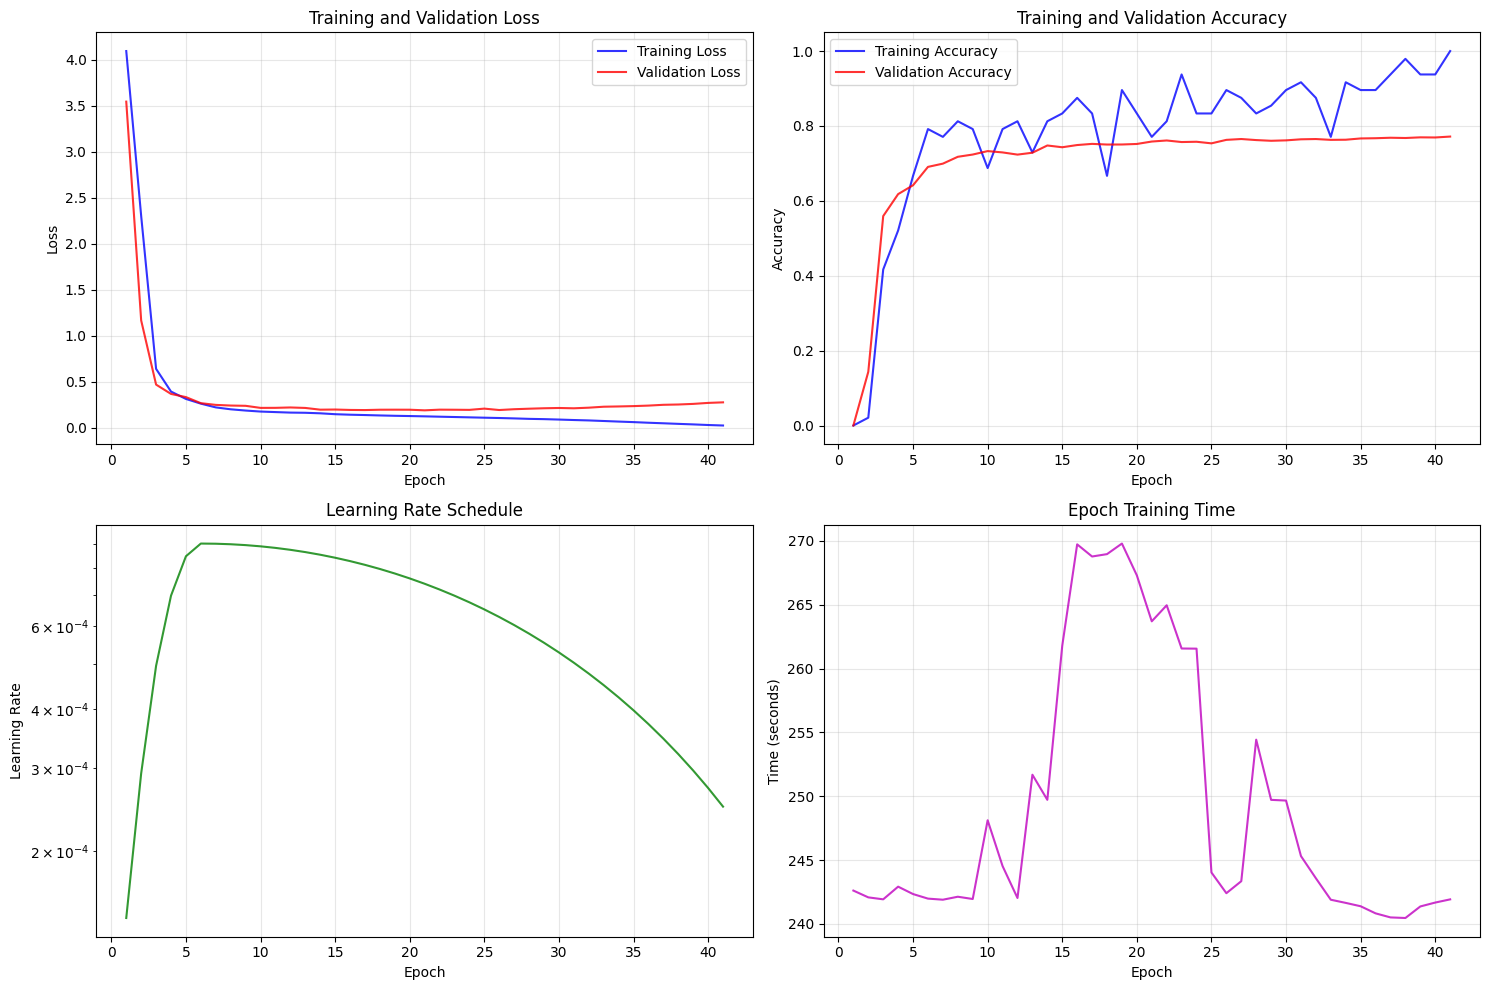


 TRAINING COMPLETED!
 Final Results:
   Best Validation Loss: 0.1912
   Best Validation Accuracy: 0.772
   Total Training Time: 2.84 hours
   Average Epoch Time: 249.2 seconds
   Total Epochs: 41
 Model saved to: training_logs\crnn_best_model.pth

 Testing final model...


 Predictions saved to training_logs/predictions.csv
 Test Results: Loss: 0.1914, Accuracy: 0.762


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CRNN(img_height=40, num_channels=1, num_classes=num_classes).to(device)

images_path = r'Dataset\captcha-dataset\preprocessed_cache\images.npy'
sparse_labels_path = r'Dataset\captcha-dataset\preprocessed_cache\sparse_labels.npy'
text_labels_path = r'Dataset\captcha-dataset\preprocessed_cache\labels.npy'

trained_model, training_history = train_model(
    model=model,
    images_path=images_path,
    sparse_labels_path=sparse_labels_path,
    text_labels_path=text_labels_path,
    chars=chars,
    device=device,
    epochs=60,
    batch_size=32,
    lr=3e-4,
    weight_decay=1e-4)

___

## **Performance**

- Exact Match Accuracy
- Character-level Accuracy
- Test on random CAPTCHA images

___

In [ ]:
import json
import os
import random
import time
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import confusion_matrix
from torchvision import transforms
from tqdm import tqdm

In [13]:
class CRNNPerformanceAnalyzer:
    def __init__(self, model, chars, device, training_logs_dir='training_logs'):
        self.model = model
        self.chars = chars
        self.device = device
        self.training_logs_dir = training_logs_dir
        self.results = {}
        
        self.analysis_dir = os.path.join(training_logs_dir, 'performance_analysis')
        os.makedirs(self.analysis_dir, exist_ok=True)
        
        print(f"   Performance Analyzer initialized")
        print(f" Character set size: {len(chars)}")
        print(f" Analysis directory: {self.analysis_dir}")
    
    def load_training_metrics(self):
        metrics_path = os.path.join(self.training_logs_dir, 'training_metrics.json')
        
        if os.path.exists(metrics_path):
            with open(metrics_path, 'r') as f:
                self.training_metrics = json.load(f)
            print(f" Training metrics loaded from {metrics_path}")
            return True
        else:
            print(f" Training metrics not found at {metrics_path}")
            return False
    
    def load_predictions(self):
        predictions_path = os.path.join(self.training_logs_dir, 'predictions.csv')
        
        if os.path.exists(predictions_path):
            self.predictions_df = pd.read_csv(predictions_path)
            print(f" Predictions loaded from {predictions_path}")
            print(f" Total predictions: {len(self.predictions_df)}")
            return True
        else:
            print(f" Predictions not found at {predictions_path}")
            return False
    
    def calculate_exact_match_accuracy(self):
        if not hasattr(self, 'predictions_df'):
            print(" No predictions loaded. Cannot calculate exact match accuracy.")
            return 0.0
        
        exact_matches = (self.predictions_df['Predicted'] == self.predictions_df['Actual']).sum()
        total_samples = len(self.predictions_df)
        exact_match_accuracy = exact_matches / total_samples
        
        self.results['exact_match_accuracy'] = exact_match_accuracy
        self.results['total_samples'] = total_samples
        self.results['exact_matches'] = exact_matches
        
        print(f" Exact Match Accuracy: {exact_match_accuracy:.4f} ({exact_matches}/{total_samples})")
        return exact_match_accuracy
    
    def calculate_character_level_accuracy(self):
        if not hasattr(self, 'predictions_df'):
            print(" No predictions loaded. Cannot calculate character-level accuracy.")
            return 0.0
        
        total_characters = 0
        correct_characters = 0
        
        for _, row in self.predictions_df.iterrows():
            predicted = str(row['Predicted']) if pd.notna(row['Predicted']) else ""
            actual = str(row['Actual']) if pd.notna(row['Actual']) else ""
            
            max_len = max(len(predicted), len(actual))
            total_characters += max_len
            
            for i in range(min(len(predicted), len(actual))):
                if predicted[i] == actual[i]:
                    correct_characters += 1
        
        char_level_accuracy = correct_characters / total_characters if total_characters > 0 else 0.0
        
        self.results['character_level_accuracy'] = char_level_accuracy
        self.results['total_characters'] = total_characters
        self.results['correct_characters'] = correct_characters
        
        print(f" Character-Level Accuracy: {char_level_accuracy:.4f} ({correct_characters}/{total_characters})")
        return char_level_accuracy
    
    def calculate_captcha_success_rate(self):
        if not hasattr(self, 'predictions_df'):
            print(" No predictions loaded. Cannot calculate success rate.")
            return 0.0
        
        success_rate = self.results.get('exact_match_accuracy', 0.0)
        
        length_analysis = defaultdict(lambda: {'total': 0, 'correct': 0})
        
        for _, row in self.predictions_df.iterrows():
            predicted = str(row['Predicted']) if pd.notna(row['Predicted']) else ""
            actual = str(row['Actual']) if pd.notna(row['Actual']) else ""
            
            actual_length = len(actual)
            length_analysis[actual_length]['total'] += 1
            
            if predicted == actual:
                length_analysis[actual_length]['correct'] += 1
        
        length_success_rates = {}
        for length, stats in length_analysis.items():
            length_success_rates[length] = stats['correct'] / stats['total'] if stats['total'] > 0 else 0.0
        
        self.results['captcha_success_rate'] = success_rate
        self.results['length_analysis'] = dict(length_analysis)
        self.results['length_success_rates'] = length_success_rates
        
        print(f"  CAPTCHA Success Rate: {success_rate:.4f}")
        print("  Success rate by CAPTCHA length:")
        for length in sorted(length_success_rates.keys()):
            rate = length_success_rates[length]
            total = length_analysis[length]['total']
            correct = length_analysis[length]['correct']
            print(f"   Length {length}: {rate:.4f} ({correct}/{total})")
        
        return success_rate
    
    def analyze_error_patterns(self):
        if not hasattr(self, 'predictions_df'):
            print("No predictions loaded. Cannot analyze error patterns.")
            return
        
        error_patterns = {
            'length_errors': {'shorter': 0, 'longer': 0, 'same': 0},
            'character_substitutions': defaultdict(int),
            'position_errors': defaultdict(int),
            'common_mistakes': defaultdict(int)}
        
        incorrect_predictions = self.predictions_df[
            self.predictions_df['Predicted'] != self.predictions_df['Actual']]
        
        for _, row in incorrect_predictions.iterrows():
            predicted = str(row['Predicted']) if pd.notna(row['Predicted']) else ""
            actual = str(row['Actual']) if pd.notna(row['Actual']) else ""
            
            if len(predicted) < len(actual):
                error_patterns['length_errors']['shorter'] += 1
            elif len(predicted) > len(actual):
                error_patterns['length_errors']['longer'] += 1
            else:
                error_patterns['length_errors']['same'] += 1
            
            min_len = min(len(predicted), len(actual))
            for i in range(min_len):
                if predicted[i] != actual[i]:
                    substitution = f"{actual[i]}->{predicted[i]}"
                    error_patterns['character_substitutions'][substitution] += 1
                    error_patterns['position_errors'][i] += 1
            
            mistake = f"'{actual}' -> '{predicted}'"
            error_patterns['common_mistakes'][mistake] += 1
        
        self.results['error_patterns'] = error_patterns
        
        print(" Error Pattern Analysis:")
        print(f"  Length errors - Shorter: {error_patterns['length_errors']['shorter']}, "
              f"Longer: {error_patterns['length_errors']['longer']}, "
              f"Same: {error_patterns['length_errors']['same']}")
        
        print("  Top 10 character substitutions:")
        top_substitutions = sorted(error_patterns['character_substitutions'].items(), 
                                 key=lambda x: x[1], reverse=True)[:10]
        for substitution, count in top_substitutions:
            print(f"    {substitution}: {count}")
    
    def analyze_character_performance(self):
        if not hasattr(self, 'predictions_df'):
            print(" No predictions loaded. Cannot analyze character performance.")
            return
        
        char_stats = defaultdict(lambda: {'total': 0, 'correct': 0, 'predicted_as': defaultdict(int)})
        
        for _, row in self.predictions_df.iterrows():
            predicted = str(row['Predicted']) if pd.notna(row['Predicted']) else ""
            actual = str(row['Actual']) if pd.notna(row['Actual']) else ""
            
            max_len = max(len(predicted), len(actual))
            for i in range(max_len):
                actual_char = actual[i] if i < len(actual) else None
                predicted_char = predicted[i] if i < len(predicted) else None
                
                if actual_char is not None:
                    char_stats[actual_char]['total'] += 1 # type: ignore
                    char_stats[actual_char]['predicted_as'][predicted_char] += 1 # type: ignore
                    
                    if actual_char == predicted_char:
                        char_stats[actual_char]['correct'] += 1 # type: ignore
        
        char_accuracies = {}
        for char, stats in char_stats.items():
            char_accuracies[char] = stats['correct'] / stats['total'] if stats['total'] > 0 else 0.0 # type: ignore
        
        self.results['character_performance'] = dict(char_stats)
        self.results['character_accuracies'] = char_accuracies
        
        print(" Character Performance Analysis:")
        print(" Character accuracies (sorted by frequency):")
        
        sorted_chars = sorted(char_stats.items(), key=lambda x: x[1]['total'], reverse=True) # type: ignore
        
        for char, stats in sorted_chars[:15]:
            accuracy = char_accuracies[char]
            print(f"    '{char}': {accuracy:.4f} ({stats['correct']}/{stats['total']})")
            
    def generate_confusion_matrix(self):
        if not hasattr(self, 'predictions_df'):
            print(" No predictions loaded. Cannot generate confusion matrix.")
            return
        
        all_actual_chars = []
        all_predicted_chars = []
        
        for _, row in self.predictions_df.iterrows():
            predicted = str(row['Predicted']) if pd.notna(row['Predicted']) else ""
            actual = str(row['Actual']) if pd.notna(row['Actual']) else ""
            
            max_len = max(len(predicted), len(actual))
            for i in range(max_len):
                actual_char = actual[i] if i < len(actual) else '<PAD>'
                predicted_char = predicted[i] if i < len(predicted) else '<PAD>'
                
                all_actual_chars.append(actual_char)
                all_predicted_chars.append(predicted_char)
        
        unique_chars = sorted(list(set(all_actual_chars + all_predicted_chars)))
        
        cm = confusion_matrix(all_actual_chars, all_predicted_chars, labels=unique_chars)
        
        self.results['confusion_matrix'] = cm
        self.results['confusion_matrix_labels'] = unique_chars
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=unique_chars, yticklabels=unique_chars)
        plt.xlabel('Predicted Character')
        plt.ylabel('Actual Character')
        plt.title('Character-level Confusion Matrix')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        
        cm_image_path = os.path.join(self.analysis_dir, "confusion_matrix.png")
        plt.tight_layout()
        plt.savefig(cm_image_path, dpi=300)
        plt.show()
        plt.close()
        
        print(f" Confusion Matrix generated and saved to {cm_image_path} ({len(unique_chars)}x{len(unique_chars)})")
        return cm, unique_chars
    
    def evaluate_on_test_set(self, test_loader):
        print("   Evaluating model on test set...")
        
        self.model.eval()
        all_predictions = []
        all_targets = []
        inference_times = []
        
        with torch.no_grad():
            for images, _, _, target_texts in tqdm(test_loader, desc="Testing"):
                start_time = time.perf_counter()
                
                images = images.to(self.device)
                logits = self.model(images)
                
                end_time = time.perf_counter()
                elapsed_ms = (end_time - start_time) * 1000
                inference_times.append(elapsed_ms)
                
                decoded = self.decode_predictions(logits)
                all_predictions.extend(decoded)
                all_targets.extend(target_texts)
        
        test_df = pd.DataFrame({
            'Predicted': all_predictions,
            'Actual': all_targets})
        
        test_results_path = os.path.join(self.analysis_dir, 'test_predictions.csv')
        test_df.to_csv(test_results_path, index=False)
        
        exact_match = (test_df['Predicted'] == test_df['Actual']).mean()
        
        total_chars = 0
        correct_chars = 0
        for pred, actual in zip(all_predictions, all_targets):
            max_len = max(len(pred), len(actual))
            total_chars += max_len
            for i in range(min(len(pred), len(actual))):
                if pred[i] == actual[i]:
                    correct_chars += 1
        
        char_accuracy = correct_chars / total_chars if total_chars > 0 else 0.0
        avg_inference_time = np.mean(inference_times) if inference_times else 0.0
        
        test_results = {
            'exact_match_accuracy': exact_match,
            'character_level_accuracy': char_accuracy,
            'total_test_samples': len(test_df),
            'average_inference_time_ms': avg_inference_time}
        
        self.results['test_results'] = test_results
        
        print(f" Test Exact Match Accuracy: {exact_match:.4f}")
        print(f" Test Character-Level Accuracy: {char_accuracy:.4f}")
        print(f" Average Inference Time: {avg_inference_time:.2f}ms")
        print(f" Test predictions saved to {test_results_path}")
        
        return test_results
    
    def decode_predictions(self, logits):
        predictions = []
        probs = F.softmax(logits, dim=2)
        _, pred_indices = torch.max(probs, dim=2)
        
        for i in range(pred_indices.size(1)):
            indices = pred_indices[:, i].cpu().numpy()
            
            decoded = []
            prev_idx = -1
            
            for idx in indices:
                if idx != 0 and idx != prev_idx:
                    if idx < len(self.chars):
                        decoded.append(self.chars[idx])
                prev_idx = idx
                
            predictions.append(''.join(decoded))
        
        return predictions
    
    def create_visualizations(self):
        print("   Creating performance visualizations...")
        
        fig = plt.figure(figsize=(20, 16))
        
        if hasattr(self, 'training_metrics'):
            plt.subplot(3, 3, 1)
            epochs = range(1, len(self.training_metrics['train_loss']) + 1)
            plt.plot(epochs, self.training_metrics['train_loss'], 'b-', label='Train Loss', alpha=0.7)
            plt.plot(epochs, self.training_metrics['val_loss'], 'r-', label='Val Loss', alpha=0.7)
            plt.title('Training & Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.subplot(3, 3, 2)
            plt.plot(epochs, self.training_metrics['train_accuracy'], 'b-', label='Train Acc', alpha=0.7)
            plt.plot(epochs, self.training_metrics['val_accuracy'], 'r-', label='Val Acc', alpha=0.7)
            plt.title('Training & Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 3, 3)
        metrics = ['Exact Match', 'Character Level', 'Success Rate']
        values = [
            self.results.get('exact_match_accuracy', 0),
            self.results.get('character_level_accuracy', 0),
            self.results.get('captcha_success_rate', 0)]
        bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        plt.title('Performance Metrics')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')
        
        if 'length_success_rates' in self.results:
            plt.subplot(3, 3, 4)
            lengths = sorted(self.results['length_success_rates'].keys())
            rates = [self.results['length_success_rates'][l] for l in lengths]
            plt.bar(lengths, rates, color='#d62728', alpha=0.7)
            plt.title('Success Rate by CAPTCHA Length')
            plt.xlabel('CAPTCHA Length')
            plt.ylabel('Success Rate')
            plt.ylim(0, 1)
        
        if 'character_accuracies' in self.results:
            plt.subplot(3, 3, (5, 6))
            char_acc = self.results['character_accuracies']
            chars_sorted = sorted(char_acc.keys())
            accuracies = [char_acc[c] for c in chars_sorted]
            
            plt.bar(range(len(chars_sorted)), accuracies, alpha=0.7)
            plt.title('Character-Level Accuracies')
            plt.xlabel('Characters')
            plt.ylabel('Accuracy')
            plt.xticks(range(len(chars_sorted)), chars_sorted, fontsize=10)
            plt.ylim(0, 1)
            plt.tight_layout()
        
        if 'error_patterns' in self.results:
            plt.subplot(3, 3, 7)
            length_errors = self.results['error_patterns']['length_errors']
            categories = ['Shorter', 'Longer', 'Same Length']
            values = [length_errors['shorter'], length_errors['longer'], length_errors['same']]
            total = sum(values)
            bars = plt.bar(categories, values, color=['#ff9999', '#66b3ff', '#99ff99'])
            plt.ylim(0, max(values) * 1.1) 
            for bar, value in zip(bars, values):
                height = bar.get_height()
                percentage = (value / total) * 100 if total > 0 else 0
                plt.text(bar.get_x() + bar.get_width()/2.0, height+total*0.02, f'{value}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=8)
            plt.ylabel('Count')
            plt.title('Length Error Distribution')
            plt.xticks(rotation=15)
        
        if 'error_patterns' in self.results:
            plt.subplot(3, 3, 8)
            subs = self.results['error_patterns']['character_substitutions']
            top_subs = sorted(subs.items(), key=lambda x: x[1], reverse=True)[:10]
            if top_subs:
                substitutions, counts = zip(*top_subs)
                plt.barh(range(len(substitutions)), counts)
                plt.title('Top Character Substitutions')
                plt.xlabel('Count')
                plt.yticks(range(len(substitutions)), substitutions)
        
        if 'error_patterns' in self.results:
            plt.subplot(3, 3, 9)
            pos_errors = self.results['error_patterns']['position_errors']
            if pos_errors:
                positions = sorted(pos_errors.keys())
                error_counts = [pos_errors[p] for p in positions]
                plt.bar(positions, error_counts, alpha=0.7)
                plt.title('Errors by Character Position')
                plt.xlabel('Character Position')
                plt.ylabel('Error Count')
        
        plt.tight_layout()
        
        viz_path = os.path.join(self.analysis_dir, 'performance_analysis.png')
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        
        print(f" Visualizations saved to {viz_path}")
        plt.show()
    
    def generate_detailed_report(self):
        print("   Generating detailed performance report...")
        
        report_path = os.path.join(self.analysis_dir, 'performance_report.txt')
        
        with open(report_path, 'w') as f:
            f.write("="*80 + "\n")
            f.write("   CRNN CAPTCHA MODEL PERFORMANCE ANALYSIS REPORT\n")
            f.write("="*80 + "\n\n")
            
            f.write("-"*40 + "\n")
            f.write("   SUMMARY METRICS\n")
            f.write("-"*40 + "\n")
            f.write(f" Exact Match Accuracy: {self.results.get('exact_match_accuracy', 0):.4f}\n")
            f.write(f" Character-Level Accuracy: {self.results.get('character_level_accuracy', 0):.4f}\n")
            f.write(f" CAPTCHA Success Rate: {self.results.get('captcha_success_rate', 0):.4f}\n")
            f.write(f" Total Samples Analyzed: {self.results.get('total_samples', 0)}\n")
            f.write(f" Exact Matches: {self.results.get('exact_matches', 0)}\n\n")
            
            if 'length_success_rates' in self.results:
                f.write("-"*40 + "\n")
                f.write("   SUCCESS RATE BY CAPTCHA LENGTH\n")
                f.write("-"*40 + "\n")
                for length in sorted(self.results['length_success_rates'].keys()):
                    rate = self.results['length_success_rates'][length]
                    total = self.results['length_analysis'][length]['total']
                    correct = self.results['length_analysis'][length]['correct']
                    f.write(f"Length {length}: {rate:.4f} ({correct}/{total})\n")
                f.write("\n")
            
            if 'character_accuracies' in self.results:
                f.write("CHARACTER-LEVEL PERFORMANCE\n")
                f.write("-"*40 + "\n")
                char_acc = self.results['character_accuracies']
                char_perf = self.results['character_performance']
                
                for char in sorted(char_acc.keys()):
                    accuracy = char_acc[char]
                    total = char_perf[char]['total']
                    correct = char_perf[char]['correct']
                    f.write(f"'{char}': {accuracy:.4f} ({correct}/{total})\n")
                f.write("\n")
            
            if 'error_patterns' in self.results:
                f.write(" ERROR PATTERN ANALYSIS\n")
                f.write("-"*40 + "\n")
                
                length_errors = self.results['error_patterns']['length_errors']
                f.write(f"Length Errors:\n")
                f.write(f" Shorter predictions: {length_errors['shorter']}\n")
                f.write(f" Longer predictions: {length_errors['longer']}\n")
                f.write(f" Same length errors: {length_errors['same']}\n\n")
                
                f.write("Top Character Substitutions:\n")
                subs = self.results['error_patterns']['character_substitutions']
                top_subs = sorted(subs.items(), key=lambda x: x[1], reverse=True)[:15]
                for substitution, count in top_subs:
                    f.write(f"  {substitution}: {count}\n")
                f.write("\n")
            
            if 'test_results' in self.results:
                f.write("-"*40 + "\n")
                f.write("   TEST SET RESULTS\n")
                f.write("-"*40 + "\n")
                test_res = self.results['test_results']
                f.write(f" Test Exact Match Accuracy: {test_res['exact_match_accuracy']:.4f}\n")
                f.write(f" Test Character-Level Accuracy: {test_res['character_level_accuracy']:.4f}\n")
                f.write(f" Total Test Samples: {test_res['total_test_samples']}\n")
                f.write(f" Average Inference Time: {test_res['average_inference_time_ms']:.2f}ms\n\n")
            
            f.write("="*80 + "\n")
            f.write("   Report generated by CRNN Performance Analyzer\n")
            f.write("="*80 + "\n")
        
        print(f" Detailed report saved to {report_path}")
    
    def save_results(self):
        results_path = os.path.join(self.analysis_dir, 'analysis_results.json')
        
        def make_json_serializable(obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, (np.integer,)):
                return int(obj)
            elif isinstance(obj, (np.floating,)):
                return float(obj)
            elif isinstance(obj, dict):
                return {k: make_json_serializable(v) for k, v in obj.items()}
            elif isinstance(obj, (list, tuple)):
                return [make_json_serializable(i) for i in obj]
            else:
                return obj
        
        json_results = {key: make_json_serializable(value) for key, value in self.results.items()}
        
        with open(results_path, 'w') as f:
            json.dump(json_results, f, indent=2)
        
        print(f" Analysis results saved to {results_path}")
    
    def run_complete_analysis(self, test_loader=None):
        print("="*60)
        print("   Starting Complete CRNN Performance Analysis")
        print("="*60)
        
        metrics_loaded = self.load_training_metrics()
        predictions_loaded = self.load_predictions()
        
        if not predictions_loaded:
            print(" No predictions file found. Analysis will be limited.")
            return
        
        self.calculate_exact_match_accuracy()
        self.calculate_character_level_accuracy()
        self.calculate_captcha_success_rate()
        self.analyze_error_patterns()
        self.analyze_character_performance()
        self.generate_confusion_matrix()
        
        if test_loader is not None:
            self.evaluate_on_test_set(test_loader)
        
        self.create_visualizations()
        self.generate_detailed_report()
        self.save_results()
        
        print("\n" + "="*60)
        print("   PERFORMANCE ANALYSIS COMPLETED!")
        print("="*60)
        print(f" Exact Match Accuracy: {self.results.get('exact_match_accuracy', 0):.4f}")
        print(f" Character-Level Accuracy: {self.results.get('character_level_accuracy', 0):.4f}")
        print(f" CAPTCHA Success Rate: {self.results.get('captcha_success_rate', 0):.4f}")
        print(f" Analysis files saved in: {self.analysis_dir}")
        print("="*60)

   Model loaded successfully.
   Performance Analyzer initialized
 Character set size: 61
 Analysis directory: training_logs\performance_analysis
   Starting Complete CRNN Performance Analysis
 Training metrics loaded from training_logs\training_metrics.json
 Predictions loaded from training_logs\predictions.csv
 Total predictions: 11306
 Exact Match Accuracy: 0.7623 (8619/11306)
 Character-Level Accuracy: 0.9096 (51449/56563)
  CAPTCHA Success Rate: 0.7623
  Success rate by CAPTCHA length:
   Length 5: 0.7623 (8619/11306)
 Error Pattern Analysis:
  Length errors - Shorter: 73, Longer: 33, Same: 2581
  Top 10 character substitutions:
    l->I: 140
    d->D: 120
    u->U: 109
    J->j: 108
    E->e: 103
    p->P: 101
    v->V: 100
    r->R: 98
    I->l: 97
    L->l: 96
 Character Performance Analysis:
 Character accuracies (sorted by frequency):
    'W': 0.9055 (929/1026)
    'w': 0.9172 (919/1002)
    'S': 0.8970 (897/1000)
    'i': 0.8798 (878/998)
    'm': 0.9165 (911/994)
    't': 0

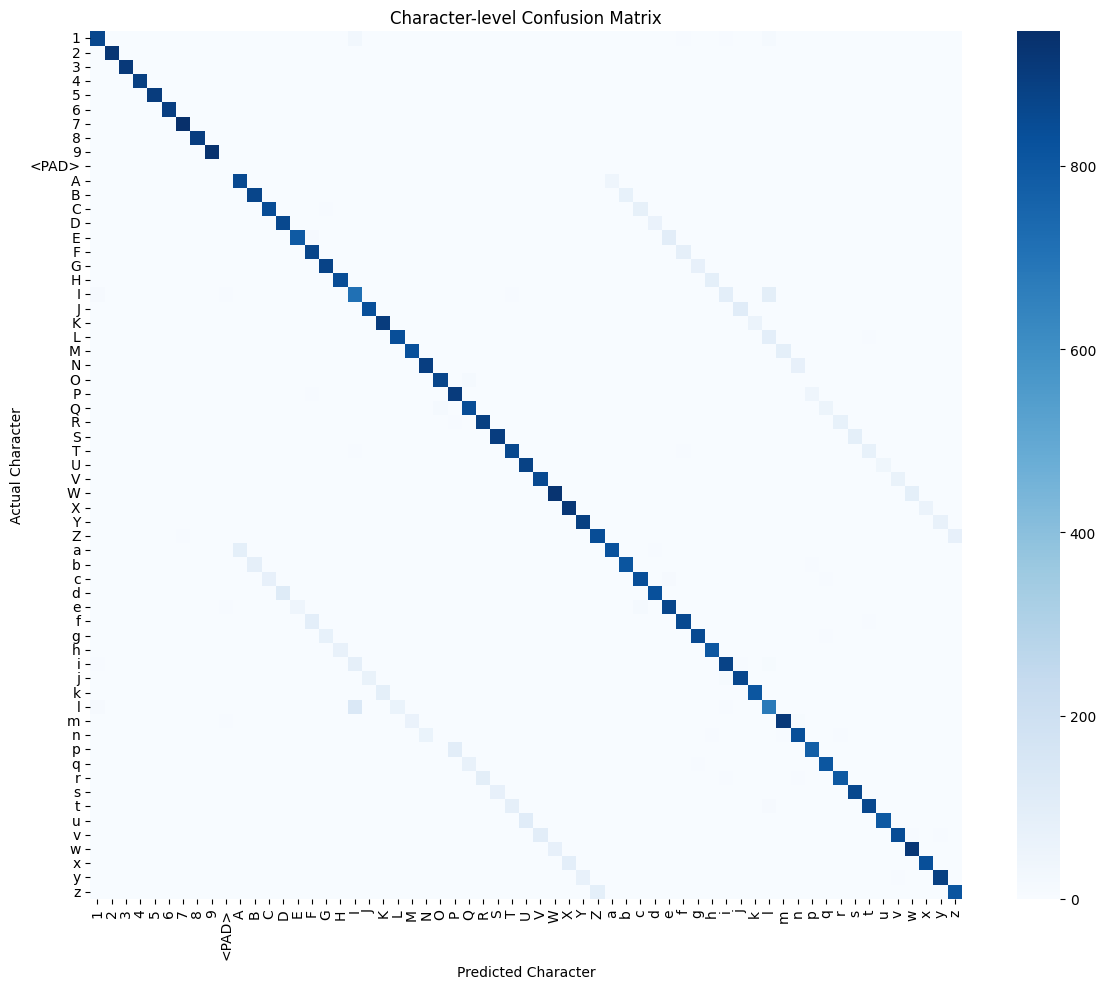

 Confusion Matrix generated and saved to training_logs\performance_analysis\confusion_matrix.png (61x61)
   Creating performance visualizations...
 Visualizations saved to training_logs\performance_analysis\performance_analysis.png


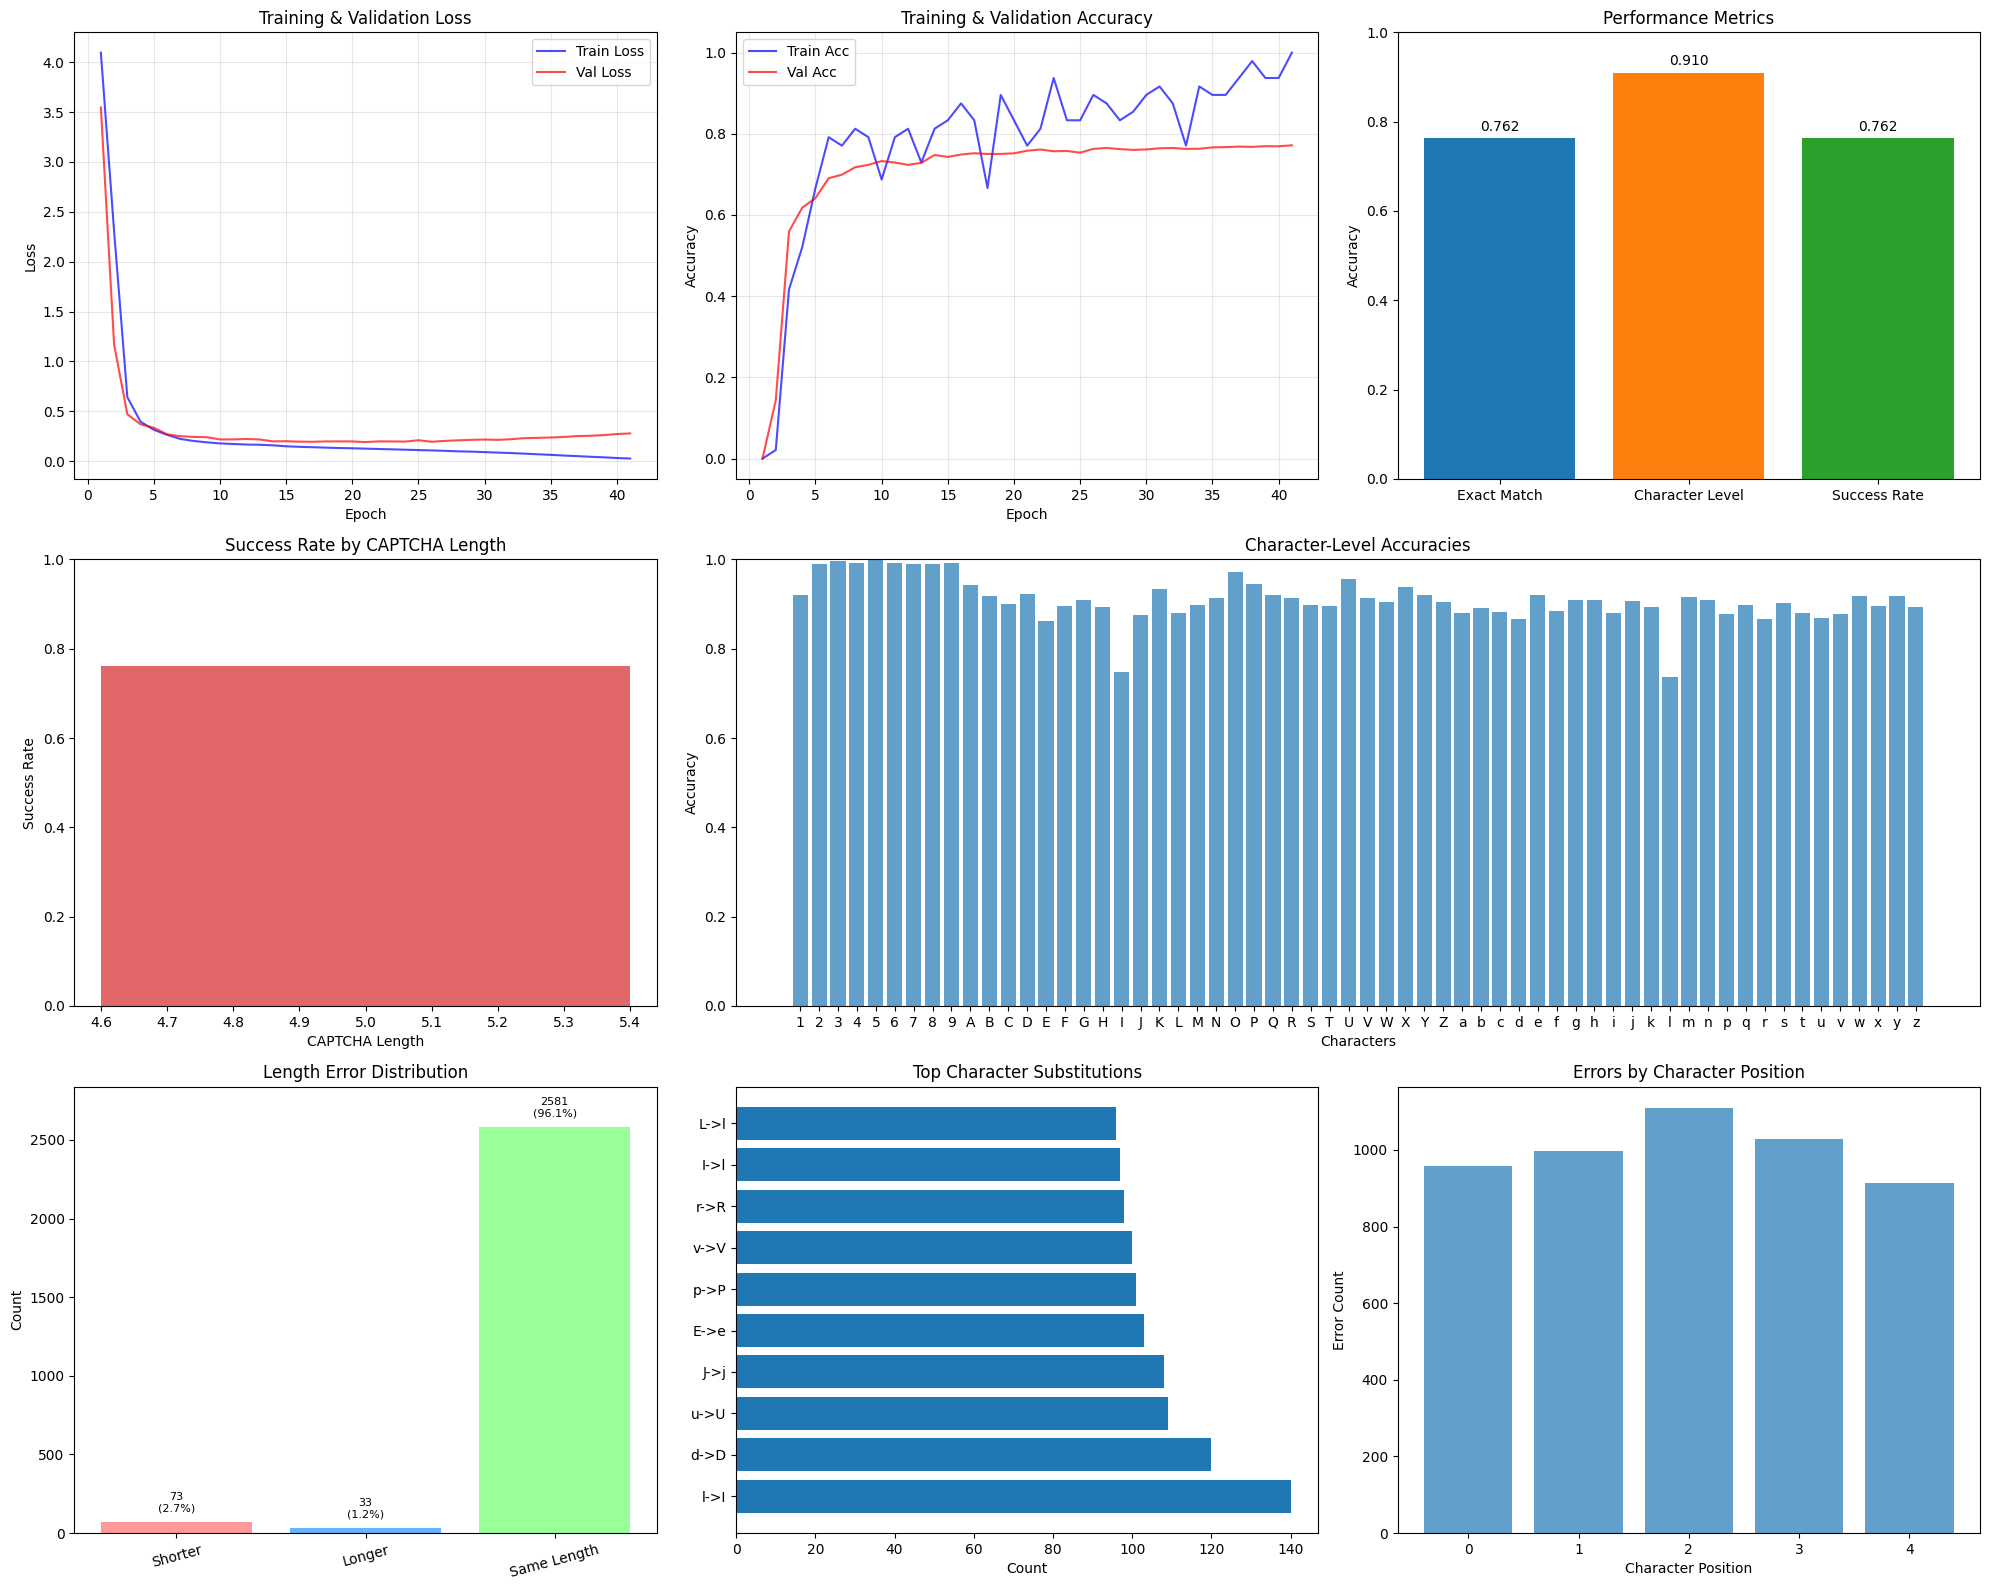

   Generating detailed performance report...
 Detailed report saved to training_logs\performance_analysis\performance_report.txt
 Analysis results saved to training_logs\performance_analysis\analysis_results.json

   PERFORMANCE ANALYSIS COMPLETED!
 Exact Match Accuracy: 0.7623
 Character-Level Accuracy: 0.9096
 CAPTCHA Success Rate: 0.7623
 Analysis files saved in: training_logs\performance_analysis


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = r'training_logs\crnn_best_model.pth'

model = CRNN(img_height=40, num_channels=1, num_classes=num_classes)
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("   Model loaded successfully.")
except FileNotFoundError:
    raise RuntimeError(f"Model file not found at path: {model_path}") 

analyzer = CRNNPerformanceAnalyzer(model=model, chars=chars, device=device, training_logs_dir='training_logs')

analyzer.run_complete_analysis(test_loader=None)

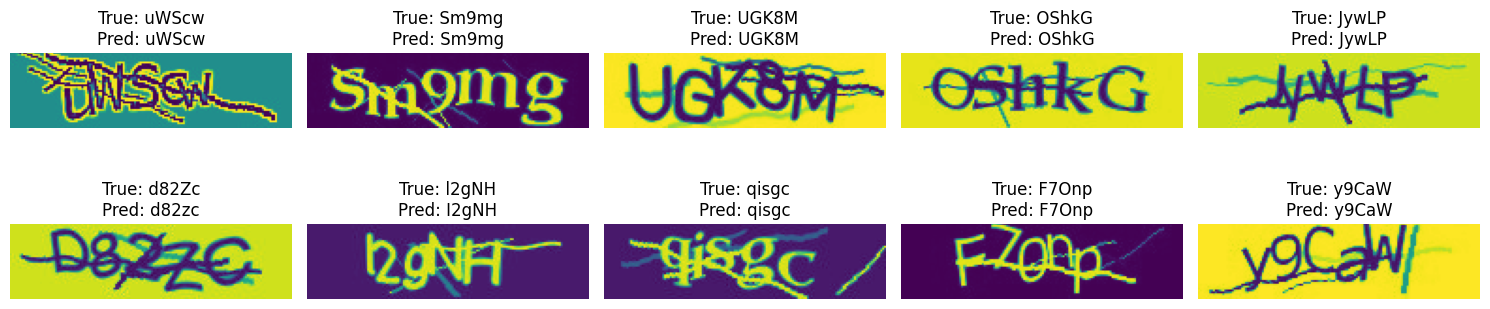

In [19]:
def decode_predictions(logits, chars):
    pred_indices = logits.argmax(dim=2).squeeze(1)
    pred_text = ''.join([chars[i] for i in pred_indices if i < len(chars)])
    return pred_text

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((40, 150)),
    transforms.ToTensor()])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = r'training_logs/crnn_best_model.pth'
model = CRNN(img_height=40, num_channels=1, num_classes=len(chars))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

test_images_dir = r'Dataset/captcha-dataset'

all_filenames = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg'))] # type: ignore

random_files = random.sample(all_filenames, 10)

plt.figure(figsize=(15, 4))
for i, filename in enumerate(random_files, 1):
    img_path = os.path.join(test_images_dir, filename)
    image = Image.open(img_path).convert("L")
    img_tensor = transform(image).unsqueeze(0).to(device)  # type: ignore 
    
    with torch.no_grad():
        output = model(img_tensor)
    
    pred_label = decode_predictions(output.cpu(), chars)
    true_label = os.path.splitext(filename)[0]
    
    plt.subplot(2, 5, i)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'True: {true_label}\nPred: {pred_label.replace(" ", "")}', fontsize=12)

plt.tight_layout()
plt.subplots_adjust()
plt.show()